# Examples Using the `dask` Module

### We can make use of the `dask` library to parallelize code

*Note:* This Jupyter notebook uses parallelization and is **not** meant to be executed within a Google Colab environment.

In [1]:
import dask
import dask.array as da
import graphviz
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np
import os
import pyrosetta
import pyrosetta.distributed
import pyrosetta.distributed.dask
import random
import sys

from dask.distributed import Client, LocalCluster, progress
from dask_jobqueue import SLURMCluster
from IPython.display import Image

if 'google.colab' in sys.modules:
    print("This Jupyter notebook uses parallelization and is therefore not set up for the Google Colab environment.")
    sys.exit(0)

/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent functio

If you are running this example on a high-performance computing (HPC) cluster with SLURM scheduling:

The `SLURMCluster` function in the `dask_jobqueue` module is very useful! In this case, we are requesting four workers using `cluster.scale(4)`, and specifying each worker to have:
- one thread per worker with `cores=1`
- one process per worker with `processes=1`
- one CPU per task per worker with `job_cpu=1`
- a total of 4GB memory per worker with `memory="4GB"`
- itself run on the "short" queue/partition on the SLURM scheduler with `queue="short"`
- have a maximum job walltime of 3 hours using `walltime="03:00:00"`
- output dask files directed to `local_directory`
- output SLURM log files directed to file path and file name (and any other SLURM commands) with the `job_extra` option

Note: `dask_jobqueue` also works with other job schedulers besides SLURM: http://jobqueue.dask.org/en/latest/api.html

In [2]:
if not os.getenv("DEBUG"):
    scratch_dir = os.path.join("/net/scratch", os.environ["USER"]) # Specify your scratch directory
    cluster = SLURMCluster(cores=1,
                           processes=1,
                           job_cpu=1,
                           memory="4GB",
                           queue="short",
                           walltime="02:59:00",
                           local_directory=scratch_dir,
                           job_extra=["-o {}".format(os.path.join(scratch_dir, "slurm-%j.out"))])
    cluster.scale(4)
    client = Client(cluster)
else:
    client = None

**Note**: The actual sbatch script submitted to the Slurm scheduler under the hood was:

In [3]:
print(cluster.job_script())

#!/bin/bash

#!/usr/bin/env bash
#SBATCH -J dask-worker
#SBATCH -p short
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=4G
#SBATCH -t 03:00:00
#SBATCH -o /scratch/klimaj/slurm-%j.out
JOB_ID=${SLURM_JOB_ID%;*}



/home/klimaj/anaconda3/envs/pyrosetta-dev/bin/python -m distributed.cli.dask_worker tcp://172.16.131.20:13609 --nthreads 1 --memory-limit 4.00GB --name dask-worker--${JOB_ID}-- --death-timeout 60 --local-directory /scratch/klimaj



Otherwise, if you are running this example locally on your laptop, you can still spawn workers and take advantage of the `dask` module:

In [4]:
# cluster = LocalCluster(n_workers=2, threads_per_worker=2)
# client = Client(cluster)

Open the `dask` dashboard, which shows diagnostic information about the current state of your cluster and helps track progress, identify performance issues, and debug failures:

In [3]:
client

Client Scheduler: tcp://172.16.131.20:31183 Dashboard: http://172.16.131.20:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Consider the following example that runs within this Jupyter notebook kernel just fine but could be parallelized:

In [4]:
def inc(x):
    return x + 1

def double(x):
    return x + 2

def add(x, y):
    return x + y

In [5]:
output = []
for x in range(10):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)
print(total)

120


With a slight modification, we can parallelize it on the HPC cluster using the `dask` module

In [6]:
output = []
for x in range(10):
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

delayed = dask.delayed(sum)(output)
print(delayed)

Delayed('sum-b4151809-88df-4493-b411-f25f9aa9d7d9')


We used the `dask.delayed` function to wrap the function calls that we want to turn into tasks. None of the `inc`, `double`, `add`, or `sum` calls have happened yet. Instead, the object total is a `Delayed` object that contains a task graph of the entire computation to be executed.

Let's visualize the task graph to see clear opportunities for parallel execution.

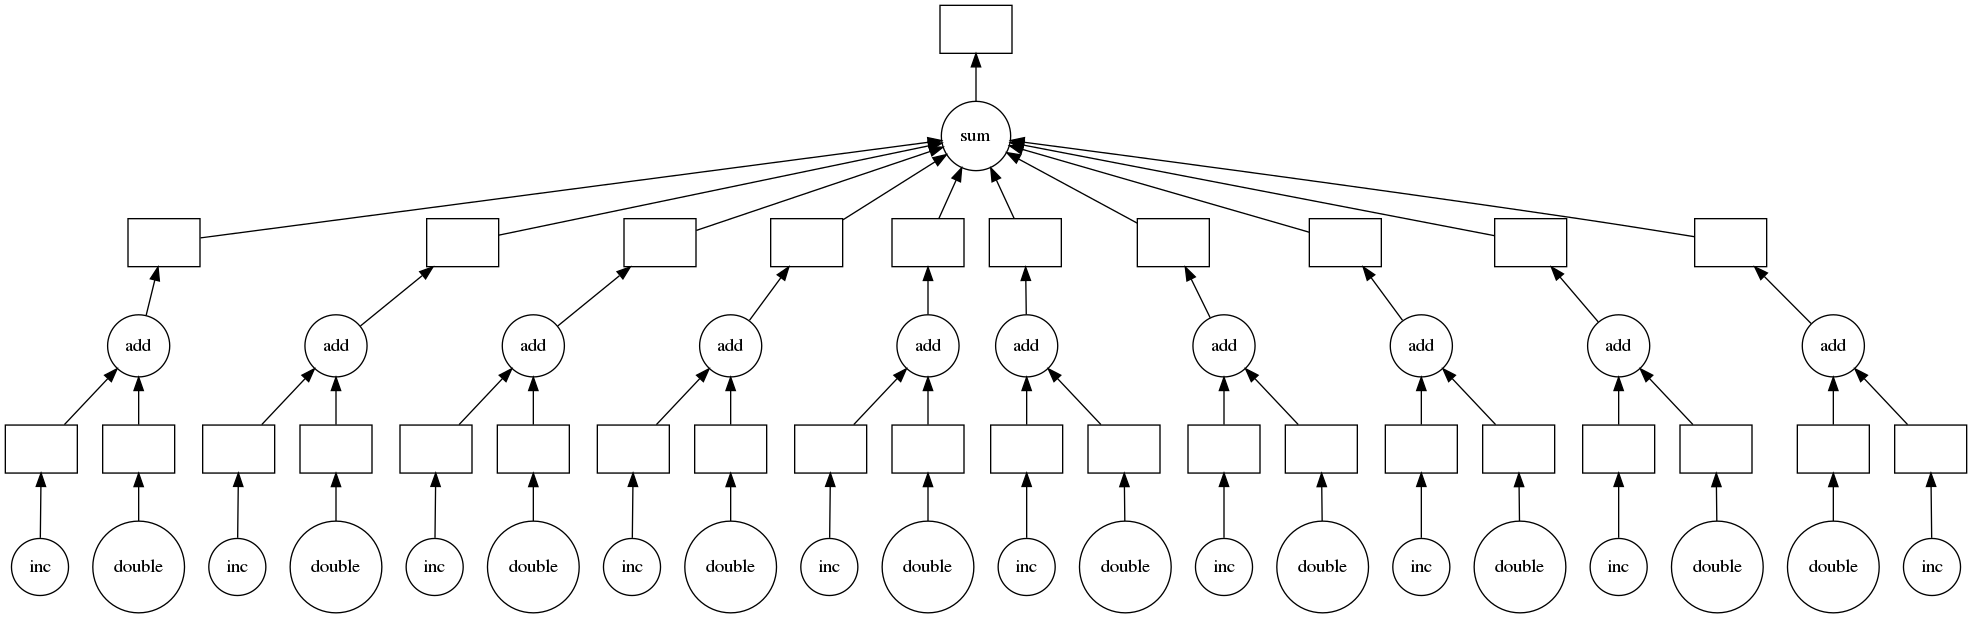

In [7]:
delayed.visualize()

We can now compute this lazy result to execute the graph in parallel:

In [8]:
if not os.getenv("DEBUG"):
    total = delayed.compute()
    print(total)

120


We can also use `dask.delayed` as a python function decorator for identical performance

In [9]:
@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x + 2

@dask.delayed
def add(x, y):
    return x + y

output = []
for x in range(10):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum)(output).compute()
print(total)

120


We can also use the `dask.array` library, which implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many parallelizable small arrays.

See `dask.array` documentation: http://docs.dask.org/en/latest/array.html, along with that of `dask.bag`, `dask.dataframe`, `dask.delayed`, `Futures`, etc.

In [10]:
if not os.getenv("DEBUG"):
    x = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
    y = da.random.random((10000, 10000, 10), chunks=(1000, 1000, 5))
    z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1, 2))
    z.compute()

The dask dashboard allows visualizing parallel computation, including progress bars for tasks. Here is a snapshot of the dask dashboard while executing the previous cell:

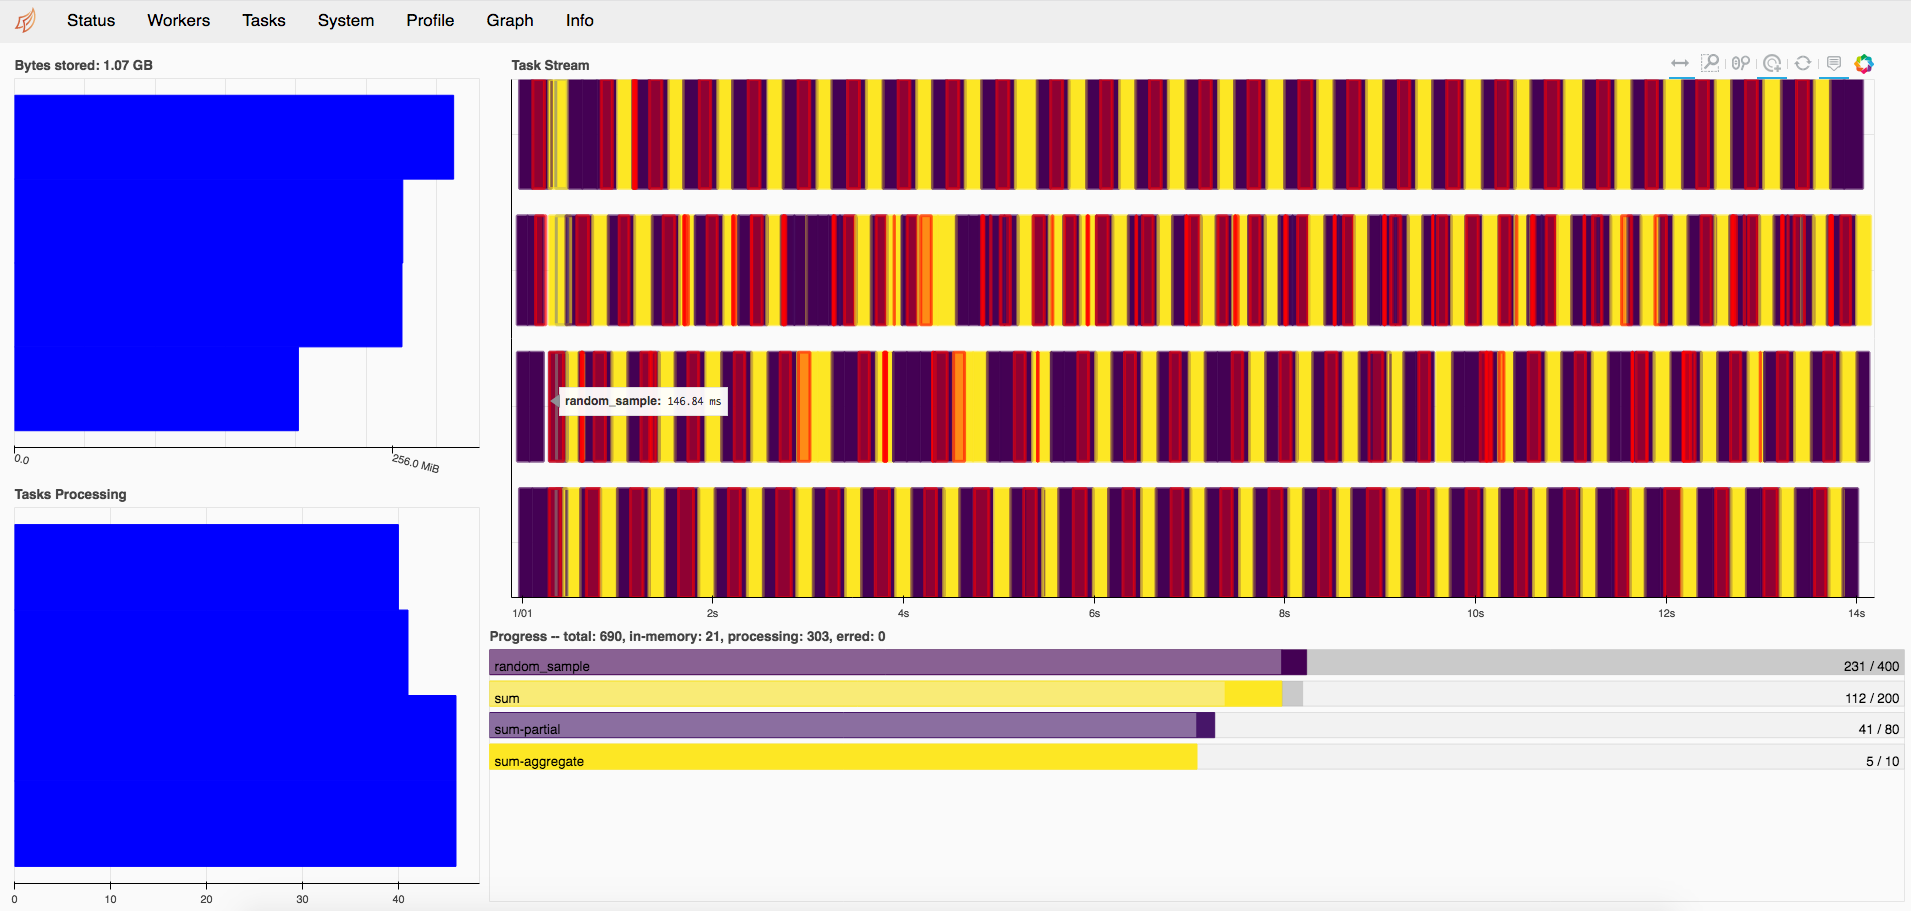

In [12]:
Image(filename="inputs/dask_dashboard_example.png") 

For more info on interpreting the dask dashboard, see: https://distributed.dask.org/en/latest/web.html

# Example Using  `dask.delayed`  with PyRosetta

Initialize PyRosetta within this Jupyter notebook using custom command line PyRosetta flags:

In [2]:
flags = """-out:level 100
-ignore_unrecognized_res   1
     -ignore_waters 0 
  -detect_disulf  0 # Do not automatically detect disulfides
""" # These can be unformatted for user convenience, but no spaces in file paths!
pyrosetta.distributed.init(flags)

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:level 100 -ignore_unrecognized_res 1 -ignore_waters 0 -detect_disulf 0', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /mnt/home/klimaj/git/Rosetta/main/source/src/python/PyRosetta/src/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python36.Release 2019.39+release.93456a567a8125cafdf7f8cb44400bc20b570d81 2019-09-26T14:24:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [3]:
if not os.getenv("DEBUG"):
    scratch_dir = os.path.join("/net/scratch", os.environ["USER"])
    cluster = SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="short",
        walltime="02:59:00",
        local_directory=scratch_dir,
        job_extra=["-o {}".format(os.path.join(scratch_dir, "slurm-%j.out"))],
        extra=pyrosetta.distributed.dask.worker_extra(init_flags=flags)
    )
    cluster.scale(4)
    client = Client(cluster)
else:
    client = None

In [4]:
client

Client Scheduler: tcp://172.16.131.20:18651 Dashboard: http://172.16.131.20:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Let's look at a simple example of sending PyRosetta jobs to the `dask-worker`, and the `dask-worker` sending the results back to this Jupyter Notebook.

We will use the crystal structure of the *de novo* mini protein gEHEE_06 from PDB ID 5JG9

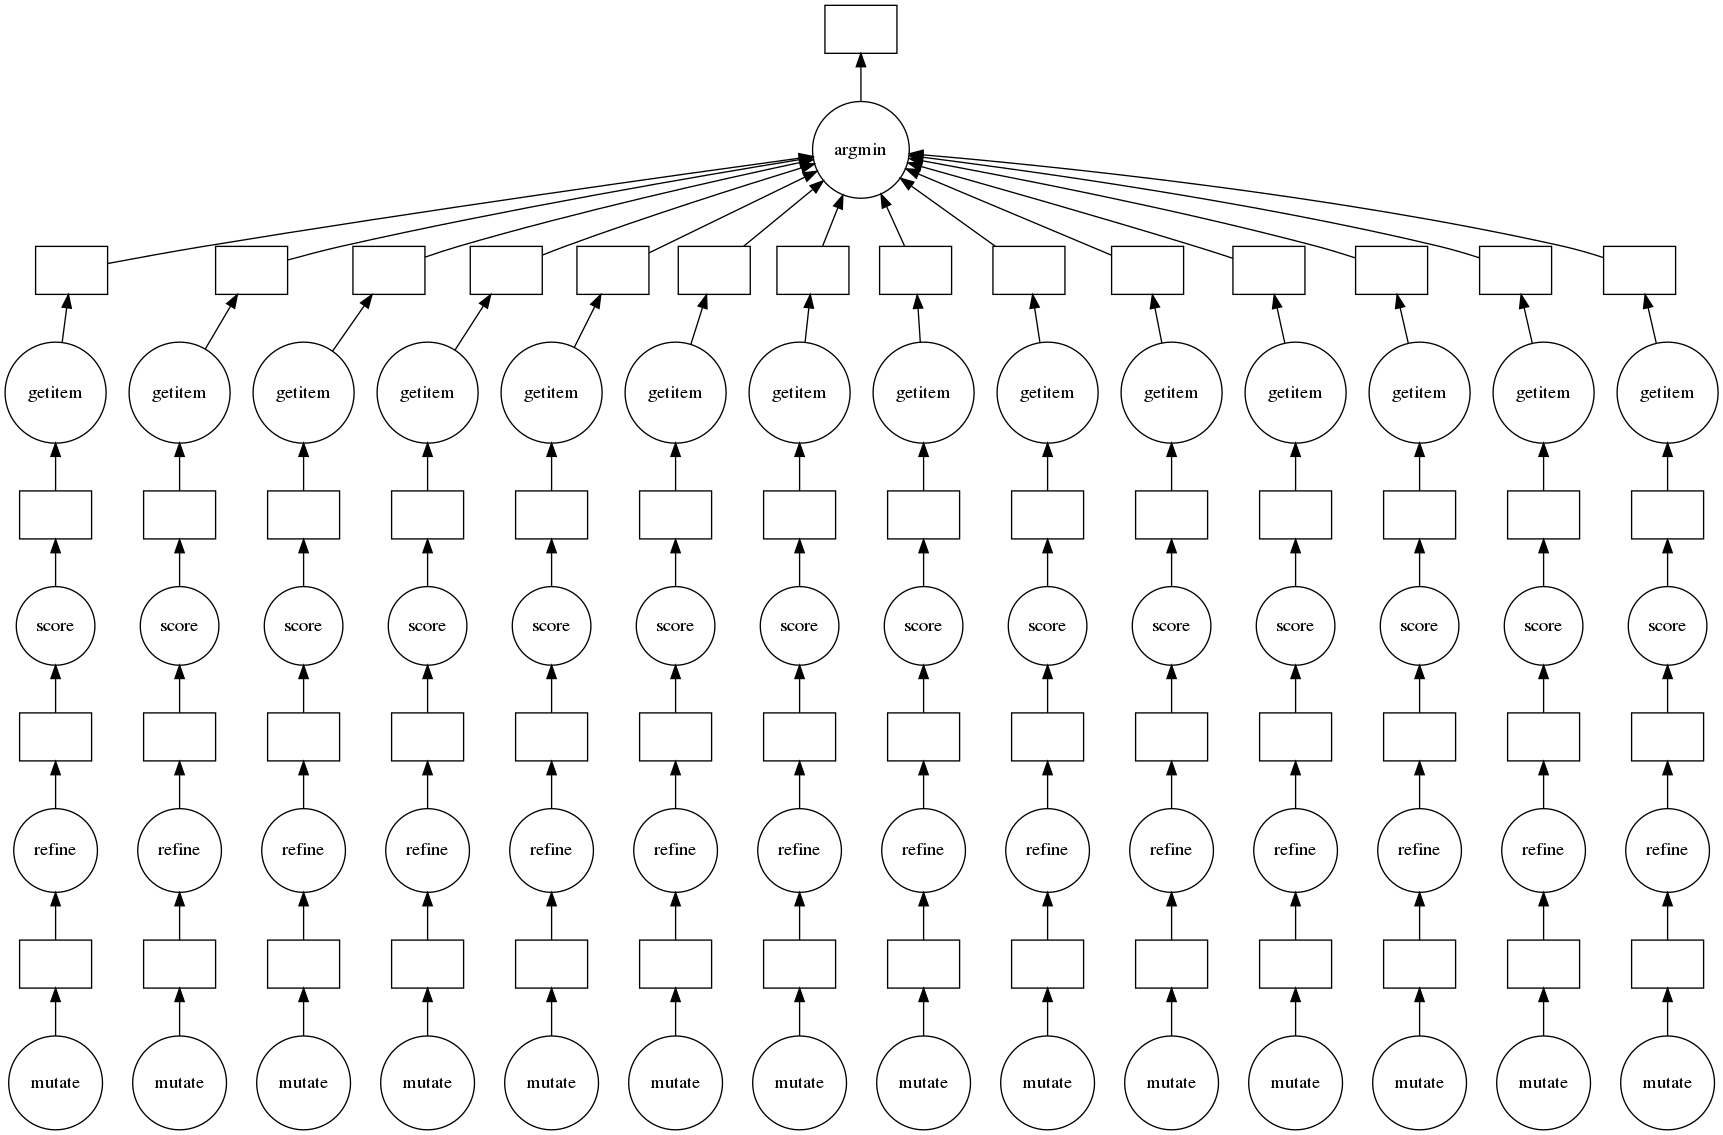

In [5]:
@dask.delayed
def mutate(pose, target, new_res):
    mutate = pyrosetta.rosetta.protocols.simple_moves.MutateResidue(target=target, new_res=new_res)
    mutate.apply(pose)
    return pose

@dask.delayed
def refine(pose):
    scorefxn = pyrosetta.create_score_function("ref2015_cart")
    mm = pyrosetta.rosetta.core.kinematics.MoveMap()
    mm.set_bb(True)
    mm.set_chi(True)
    min_mover = pyrosetta.rosetta.protocols.minimization_packing.MinMover()
    min_mover.set_movemap(mm)
    min_mover.score_function(scorefxn)
    min_mover.min_type("lbfgs_armijo_nonmonotone")
    min_mover.cartesian(True)
    min_mover.tolerance(0.01)
    min_mover.max_iter(200)
    min_mover.apply(pose)
    return pose

@dask.delayed
def score(pose):
    scorefxn = pyrosetta.create_score_function("ref2015")
    total_score = scorefxn(pose)
    return pose, total_score


pose = pyrosetta.io.pose_from_file("inputs/5JG9.clean.pdb")
keep_chA = pyrosetta.rosetta.protocols.grafting.simple_movers.KeepRegionMover(
    res_start=str(pose.chain_begin(1)), res_end=str(pose.chain_end(1))
)
keep_chA.apply(pose)

output = []
for target in random.sample(range(1, pose.size() + 1), 10):
    if pose.sequence()[target - 1] != "C":
        for new_res in ["ALA", "TRP"]:
            a = mutate(pose, target, new_res)
            b = refine(a)
            c = score(b)
            output.append((target, new_res, c[0], c[1]))

delayed_obj = dask.delayed(np.argmin)([x[-1] for x in output])
delayed_obj.visualize()

In [6]:
print(output)

[(7, 'ALA', Delayed('getitem-d9875d2bd06a3b4eb29c045acdcda83b'), Delayed('getitem-831ffa6469dbcaefa2055435636e0d9a')), (7, 'TRP', Delayed('getitem-773e49bbe7bc11d7ae151e7762202e0c'), Delayed('getitem-560b80b2c3ebb74f2707123672b96ed5')), (32, 'ALA', Delayed('getitem-245a835885144cf37d5d5d3bc32f57c1'), Delayed('getitem-1a04ef8137a91685ec394b430a6f6198')), (32, 'TRP', Delayed('getitem-5243b2e565167e8aab89ffc3194dd135'), Delayed('getitem-bb8f42891fc71672c17c1b6e085b9904')), (4, 'ALA', Delayed('getitem-8b1fbbb06f67f843cb3cd4b604b3a7f6'), Delayed('getitem-f9af11021033725451c0df0ca9ac0dde')), (4, 'TRP', Delayed('getitem-ad52f27cdc3170d7ccafca977718f831'), Delayed('getitem-896f46c25d3355e904797ac1bc2bf717')), (2, 'ALA', Delayed('getitem-ed89b8f356747b9ddc00538255107083'), Delayed('getitem-bcb54e7326288588ee19352855a31e44')), (2, 'TRP', Delayed('getitem-63f274219de7e0c4018517b9b4d391d9'), Delayed('getitem-1c1b4c6b993772f864a2a650850a7217')), (26, 'ALA', Delayed('getitem-1d17a2b954ce758c9638c172

In [7]:
if not os.getenv("DEBUG"):
    delayed_result = delayed_obj.persist()
    progress(delayed_result)

AttributeError: module 'pyrosetta.rosetta' has no attribute '__path__'

In [ ]:
if not os.getenv("DEBUG"):
    result = delayed_result.compute()
    print("The mutation with the lowest energy is residue {0} at position {1}".format(output[result][1], output[result][0]))

In [7]:
sys.path

['',
 '/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python36.zip',
 '/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6',
 '/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/lib-dynload',
 '/home/klimaj/.local/lib/python3.6/site-packages',
 '/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages',
 '/mnt/home/klimaj/git/Rosetta/main/source/src/python/PyRosetta/src',
 '/home/klimaj/anaconda3/envs/pyrosetta-dev/lib/python3.6/site-packages/IPython/extensions',
 '/mnt/home/klimaj/.ipython']

*Note*: For best practices while using `dask.delayed`, see: http://docs.dask.org/en/latest/delayed-best-practices.html